Epoch [1/10], Loss: 0.0678
Epoch [2/10], Loss: 0.0315
Epoch [3/10], Loss: 0.0239
Epoch [4/10], Loss: 0.0203
Epoch [5/10], Loss: 0.0182
Epoch [6/10], Loss: 0.0167
Epoch [7/10], Loss: 0.0155
Epoch [8/10], Loss: 0.0148
Epoch [9/10], Loss: 0.0143
Epoch [10/10], Loss: 0.0139


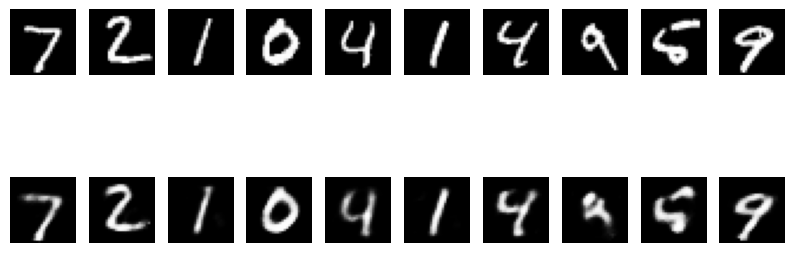

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
input_dim = 784
latent_dim = 32
hidden_dim = 128
batch_size = 256
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Autoencoder model
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# Data (MNIST flattened to 784)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 -> 784
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = AutoEncoder(input_dim, hidden_dim, latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Get some reconstructions
model.eval()
with torch.no_grad():
    test_batch, _ = next(iter(test_loader))
    test_batch = test_batch.to(device)
    reconstructed = model(test_batch[:10])
    reconstructed = reconstructed.cpu().numpy()
    originals = test_batch[:10].cpu().numpy()

# Plot images
def plot_images(original, reconstructed):
    plt.figure(figsize=(10, 4))
    for i in range(10):
        # Original
        plt.subplot(2, 10, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        # Reconstructed
        plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

plot_images(originals, reconstructed)
